# Introduction
Zyfra is a company develops efficiency solutions for heavy industry. I will prepare a prototype of a machine learning model for data they have gathered on extraction and purification. The model should predict the amount of gold recovered from gold ore. The model will help to optimize the production and eliminate unprofitable parameters.

##### Data Description
The data comprises of three datasets:
- The full data on gold recovery from the warehouse.
- A training dataset, which contains the majority of observations from the full data.
- A testing dataset, which comprises of the rest of the observations from the full data, but does not contain any retroactively-calculated columns, target columns icluded.

Each of the 87 column names is contructed this way: [stage].[parameter_type].[parameter_name]

Example: rougher.input.feed_ag

Possible values for [stage], by order of occurence during ore processing:
- rougher — the floatation stage.
- primary_cleaner — primary purification.
- secondary_cleaner — secondary purification.
- final — final characteristics.

Possible values for [parameter_type]:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics


### Initialising

In [1]:
# necessary
import pandas as pd
import numpy as np
import math
from scipy import stats as st
from datetime import datetime

import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objects as go

from sklearn import model_selection as sel, metrics as met, preprocessing as pro
from sklearn import dummy as dum, multioutput as mul
from sklearn import svm, tree, ensemble as ens, linear_model as lin

import joblib as jbl

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore") 

##### Loading Datasets

In [2]:
try:
    gold_full = pd.read_csv('gold_recovery_full.csv', parse_dates = ['date'])
    gold_test = pd.read_csv('gold_recovery_test.csv', parse_dates = ['date'])
    gold_train = pd.read_csv('gold_recovery_train.csv', parse_dates = ['date'])
except:
    gold_full = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates = ['date'])
    gold_test = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates = ['date'])
    gold_train = pd.read_csv('/datasets/gold_recovery_train.csv', parse_dates = ['date'])


##### A Look at the Datasets
In this section I will:
- Become familiar with the data
- Search for errors

In [3]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

87 columns, out of which only two columns don't contain any nulls - the 'date' and 'primary_cleaner.input.feed_size' columns. The rest of the columns arev missing plenty of values, each a different amount.

In [4]:
gold_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


The observations appear to be measured on an hourly basis.

In [5]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16788 non-null  float64       
 2   final.output.concentrate_pb                         16788 non-null  float64       
 3   final.output.concentrate_sol                        16490 non-null  float64       
 4   final.output.concentrate_au                         16789 non-null  float64       
 5   final.output.recovery                               15339 non-null  float64       
 6   final.output.tail_ag                                16794 non-null  float64       
 7   final.output.tail_pb                                16677 non-null  float64       
 8   final.

Again there are nulls in 85 out of the 87 columns, with the full columns being 'primary_cleaner.input.feed_size' and 'date'. When transfering output from the floatation stage to become input in the primary cleaning stage, it seems a lot of care is put into measuring that specifically.

In [6]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5554 non-null   float64       
 2   primary_cleaner.input.depressant            5572 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5690 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64       
 9   primary_

The same two columns as before are the only two columns without nulls in this dataset as well, but they are two columns out of 53. Many of the measurements of states during different stages are lacking precisely 16 observations, which is not much out of the dataset, but it is curious.

In [7]:
gold_test[gold_test['secondary_cleaner.state.floatbank6_a_level'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 612 to 3037
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        16 non-null     datetime64[ns]
 1   primary_cleaner.input.sulfate               0 non-null      float64       
 2   primary_cleaner.input.depressant            0 non-null      float64       
 3   primary_cleaner.input.feed_size             16 non-null     float64       
 4   primary_cleaner.input.xanthate              0 non-null      float64       
 5   primary_cleaner.state.floatbank8_a_air      0 non-null      float64       
 6   primary_cleaner.state.floatbank8_a_level    0 non-null      float64       
 7   primary_cleaner.state.floatbank8_b_air      0 non-null      float64       
 8   primary_cleaner.state.floatbank8_b_level    0 non-null      float64       
 9   primary_

There are 16 rows in the test dataset that in which only the feed size was measured. Removing rows with null values in them will be a good course of action when preprocessing.

I'll check whether there is a similar error in the training dataset.

In [8]:
emptysearch = gold_train.drop(['date', 'primary_cleaner.input.feed_size'], axis = 1)
emptysearch[emptysearch.isnull().all(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 746 to 1312
Data columns (total 85 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         0 non-null      float64
 1   final.output.concentrate_pb                         0 non-null      float64
 2   final.output.concentrate_sol                        0 non-null      float64
 3   final.output.concentrate_au                         0 non-null      float64
 4   final.output.recovery                               0 non-null      float64
 5   final.output.tail_ag                                0 non-null      float64
 6   final.output.tail_pb                                0 non-null      float64
 7   final.output.tail_sol                               0 non-null      float64
 8   final.output.tail_au                                0 non-null      float64
 9 

There are such observations in the training dataset that contain only the date and the feed size, but only 4 out of all 16,860 rows compared to 16 out of 5,856 in the testing data.

In [9]:
print('full data', gold_full.shape,'train_data', gold_train.shape, 'test_data', gold_test.shape)

full data (22716, 87) train_data (16860, 87) test_data (5856, 53)


16,860 rows out of 22,716 is 74.2%, and 5,856 rows out of 22,716 is 25.8%. 5,856 and 16,860 add up to 22,716 as they should. The split into training and testing datasets appears correct so far, and the proportions seem good as well.

In [10]:
feature_names = set(gold_test.columns)
all_names = set(gold_full.columns)
non_features = list(all_names-feature_names)
non_features

['rougher.output.recovery',
 'rougher.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'final.output.tail_ag',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_pb',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'final.output.tail_sol',
 'rougher.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'final.output.concentrate_sol',
 'final.output.tail_pb',
 'rougher.output.concentrate_ag',
 'rougher.output.tail_ag',
 'final.output.concentrate_ag',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.concentrate_au',
 'secondary_cleaner.output.tail_pb',
 'final.output.tail_au',
 'final.output.concentrate_au',
 'secondary_cleaner.output.tail_au',
 'rougher.output.concentrate_sol',
 'rougher.calculation.sulfate_to_au_concentrate',
 'final.output.concentrate_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'primary_cleaner.output.concentrate_sol',
 'rougher.calculation.

The column names in the testing dataset are missing all columns that are only calculated after the fact - essentially, all data that the model I am planning to train will not have access to when predicting for a business. My target columns are only 'rougher.output.recovery' and 'final.output.recovery', but all of the columns missing from the testing dataset will have to be removed from the training features to avoid target leakage.

I'd like to take a closer look at the data I will be using for recovery calculation. For example, let's take the data about the floatation stage from the full dataset.
##### Defining Function
subgroup
- Accepts a pandas dataframe and a string.
- Returns a dataframe of only the columns whos names start with the string.

In [11]:
stages = ['rougher','primary_cleaner','secondary_cleaner','final']
parameter_types = ['input','output','state','calculation']

def subgroup(data, #a pandas dataframe
             beginning): #a string at the start of the relevant column names
    ret = data
    for col in data.columns: #iterates over a series of strings
        if not col.startswith(beginning):
            ret = ret.drop(col, axis = 1) #drops all columns not starting with the beginning
    return ret


In [12]:
#viewing one stage for example
float_full = subgroup(gold_full, stages[0])
float_full.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 35 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.calculation.sulfate_to_au_concentrate       22672 non-null  float64
 1   rougher.calculation.floatbank10_sulfate_to_au_feed  22672 non-null  float64
 2   rougher.calculation.floatbank11_sulfate_to_au_feed  22672 non-null  float64
 3   rougher.calculation.au_pb_ratio                     21089 non-null  float64
 4   rougher.input.feed_ag                               22618 non-null  float64
 5   rougher.input.feed_pb                               22472 non-null  float64
 6   rougher.input.feed_rate                             22163 non-null  float64
 7   rougher.input.feed_size                             22277 non-null  float64
 8   rougher.input.feed_sol                              22357 non-null  float64


I'd like to take a deeper look into some of the columns.

In [13]:
float_full[[
    'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au'
]].describe()

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au
count,22617.000000,22618.000000,19980.000000
mean,7.565838,17.879538,1.821193
std,3.026954,6.790112,0.695663
min,0.000000,0.000000,0.020676
25%,6.485009,17.928729,1.403951
50%,7.884832,20.003202,1.808567
75%,9.668064,21.564238,2.215317
max,14.093363,28.824507,9.688980


These columns are the columns used to calculate the floatation recovery, which is one of the two targets for this project. I'd like to take a closer look at them.
They each represent precentages. None contain a value lower than 0 or unreasonably high, so they seems reliable. The tail column has many more nulls than the other two columns.

In [14]:
float_full[[
    'rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol','rougher.input.feed_au'
]].describe()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au
count,22618.000000,22472.000000,22357.000000,22617.000000
mean,8.065715,3.305676,33.276016,7.565838
std,3.125250,1.446905,11.494135,3.026954
min,0.000000,0.000000,0.000000,0.000000
25%,6.944415,2.658814,32.524264,6.485009
50%,8.302613,3.432054,36.559955,7.884832
75%,10.135202,4.204960,39.675470,9.668064
max,14.869652,7.142594,53.477742,14.093363


These are the precentages of all recorded materials out of the initial feed. Even their highest values combined do not add up to 100% - not all substances are recorded. The minimum values are all zeroes.

In [15]:
float_full[[
    'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 
    'rougher.output.concentrate_sol', 'rougher.output.concentrate_au'
]].describe()

,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au
count,22618.000000,22618.000000,22526.000000,22618.000000
mean,10.874484,6.900646,26.095508,17.879538
std,4.377924,2.806948,10.140120,6.790112
min,0.000000,0.000000,0.000000,0.000000
25%,10.126646,6.374692,25.815139,17.928729
50%,11.785127,7.572855,29.382638,20.003202
75%,13.615299,8.477358,32.002766,21.564238
max,24.480271,18.394042,40.089993,28.824507


The averages ond maximum values of the shares of the metals increased, and those same values lowered for sol, the only non-metal recorded.

In [16]:
float_full[[
    'rougher.output.tail_ag','rougher.output.tail_pb',
    'rougher.output.tail_sol','rougher.output.tail_au'
]].describe()

,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au
count,19979.000000,22618.000000,19980.000000,19980.000000
mean,5.587861,0.593620,18.040138,1.821193
std,1.114614,0.315295,3.470514,0.695663
min,0.594562,0.000000,10.014648,0.020676
25%,4.887758,0.427513,15.788283,1.403951
50%,5.759630,0.590746,18.082595,1.808567
75%,6.386301,0.763219,20.084427,2.215317
max,12.719177,3.778064,66.117188,9.688980


There are much fewer non-null values in the tail columns, and coincidentally, the minimum values for most of the tail columns are higher than 0, as opposed to the rest of the columns representing shares, that do have values of 0 in them. It's possible many of these nulls are covering for 0, however, there are too many nulls in these to simply fill all with zeros.

Before I preprocess the daa, I still need to check one more thing. The indexes for each of the datasets are automatically generated, which means in order to find the matching target values for the test features, the index for the test dataset will not help me. I have to match target values to observations according to the date, so I have to make sure there are no times that ended up in both training and testing datasets, and no times that appear twice in the full data.

In [17]:
full_dates = pd.concat([gold_train.date, gold_test.date])
full_dates[full_dates.duplicated()]

Series([], Name: date, dtype: datetime64[ns])

No duplicated times among training and testing datasets.

In [18]:
gold_full.date[gold_full.date.duplicated()]

Series([], Name: date, dtype: datetime64[ns])

No duplicated times in the full data.

### Data Preparation
The target columns that my model should learn to predict are: 
- 'rougher.output.recovery' - gold recovery after the floatation stage.
- 'final.output.recovery' - gold recovery at the end of the entire gold extraction process.

The data that is necessary to calculate each of these kinds of recovery is:
- For floatation recovery:
    - 'rougher.input.feed_au' - the share of gold out of the raw mined ore.
    - 'rougher.output.tail_au' - the share of gold out of the product residues from the floatation stage.
    - 'rougher.output.concentrate_au' - the share of gold out of the output of the floatation stage, which will also be the feed of the rest of the process.
- For final recovery:
    - 'rougher.input.feed_au' - the share of gold in the initial feed.
    - 'final.output.tail_au' - the share of gold out of the combined residues from all stages.
    - 'final.output.concentrate_au' - the share of gold in the final product.


In [19]:
recovery_calculation = pd.Series(['rougher.input.feed_au',
                                  'rougher.output.tail_au', 'rougher.output.concentrate_au',
                                  'final.output.tail_au', 'final.output.concentrate_au'])
recovery_calculation[~recovery_calculation.isin(non_features)]

0    rougher.input.feed_au
dtype: object

Of the data necessary for recovery calculation, only one column will be part of the features.

I will calculate each recovery and compare it to each target column in the full data.

I will also fill null values using two methods, interpolation and forward-filling, and use the data on recovery to find which one of the methods would disrupt the calculation less than the other. I will be focusing my comparison on the gold feeds, since the formula for recovery includes division by feed, so to avoid dividing by zero I return 0% as recovery for every observation of 0% gold in feed. 

It is also worth noting that the initial feed will be in the features and is closely tied to the target, so it is important for the model's learning that the degree of correlation between recovery and share of gold in the feed will be unchanged.
##### Defining Functions
- recovery_precent
    - Accepts the shares, in precentages, of gold in relevant stages of the ore purification process.
    - Calculates gold recovery based on these numbers and returns it.
- recovery
    - Accepts the relevant shares of gold, each as a pandas Series, and an index of matching length.
    - Applies the recovery_precent function to each row.
    - Returns a pandas Series of recoveries.

In [20]:
def recovery_precent(c, #share of gold after flotation/purification
            f, #share of gold before flotation/ after floatation
            t): #share of gold in tails after floatation/purification
    if (f == 0) or ((c-t) == 0): #can't divide by 0
        return 0
    else: return ((c*(f-t))/(f*(c-t)))*100

def recovery(c_col, f_col, t_col, ind):
    ret = []
    for c,f,t in zip(c_col, f_col, t_col):
        ret.append(recovery_precent(c=c,f=f,t=t))
    ret = pd.Series(ret, ind)
    return ret

In [21]:
train = gold_train.set_index('date').interpolate(method = 'time')
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16860 non-null  float64
 1   final.output.concentrate_pb                         16860 non-null  float64
 2   final.output.concentrate_sol                        16860 non-null  float64
 3   final.output.concentrate_au                         16860 non-null  float64
 4   final.output.recovery                               16860 non-null  float64
 5   final.output.tail_ag                                16860 non-null  float64
 6   final.output.tail_pb                                16860 non-null  float64
 7   final.output.tail_sol                               16860 non-null  float64
 8   final.output.tail_au                     

I believe, in this case, that observations that are chronologically close are more similar to one another than just any two observations.

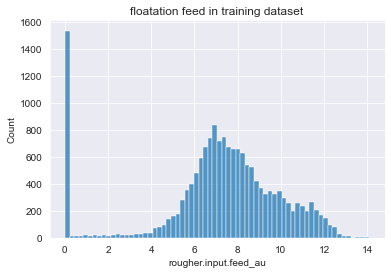

In [22]:
sns.histplot(gold_train['rougher.input.feed_au'])
plt.title('floatation feed in training dataset')
plt.show()

There is a peak of zeros in the distribution of gold feed shares.

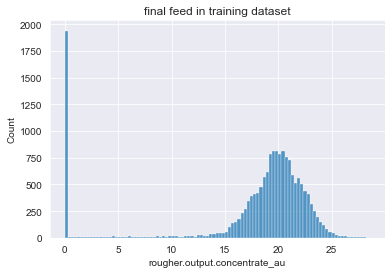

In [23]:
sns.histplot(gold_train['rougher.output.concentrate_au'])
plt.title('final feed in training dataset')
plt.show()

The output from the floatation stage has even more zeros. Between 13% and 28%, the gold concentration seems almost normally distributed.

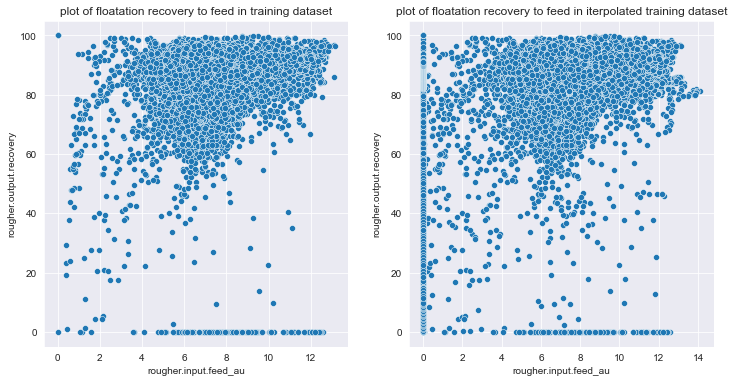

In [24]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
sns.scatterplot(x = gold_train['rougher.input.feed_au'],
               y = gold_train['rougher.output.recovery'])
plt.title('plot of floatation recovery to feed in training dataset')

plt.subplot(1,2,2)
sns.scatterplot(x = train['rougher.input.feed_au'],
               y = train['rougher.output.recovery'])
plt.title('plot of floatation recovery to feed in iterpolated training dataset')
plt.show()


The correlation between the gold precentage in the feed and the floatation recovery is much less clear when the data is interpolated.

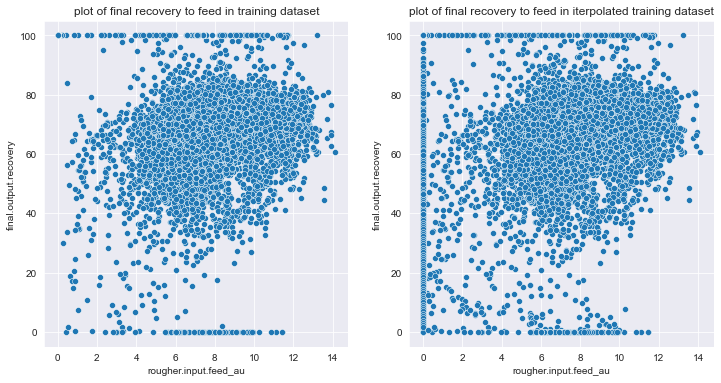

In [25]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
sns.scatterplot(x = gold_train['rougher.input.feed_au'],
               y = gold_train['final.output.recovery'])
plt.title('plot of final recovery to feed in training dataset')

plt.subplot(1,2,2)
sns.scatterplot(x = train['rougher.input.feed_au'],
               y = train['final.output.recovery'])
plt.title('plot of final recovery to feed in iterpolated training dataset')
plt.show()


The same goes for the final recovery.

In [26]:
rougher_recovery = train['rougher.output.recovery']
rougher_pred = recovery(c_col = train['rougher.output.concentrate_au'], 
                        f_col = train['rougher.input.feed_au'], 
                        t_col = train['rougher.output.tail_au'],
                       ind = train.index)

final_recovery = train['final.output.recovery']
final_pred = recovery(c_col = train['final.output.concentrate_au'], 
                        f_col = train['rougher.input.feed_au'], 
                        t_col = train['final.output.tail_au'],
                       ind = train.index)

print('Rougher MAE calculated from interpolated data:',
      met.mean_absolute_error(rougher_recovery, rougher_pred),
     '\nFinal stage MAE:',
      met.mean_absolute_error(final_recovery, final_pred))

Rougher MAE calculated from interpolated data: 58.34673425794583 
Final stage MAE: 44.999304298356755


In [27]:
ffill_train = gold_train.fillna(method='ffill')
rougher_recovery = ffill_train['rougher.output.recovery']
rougher_pred = recovery(c_col = ffill_train['rougher.output.concentrate_au'], 
                        f_col = ffill_train['rougher.input.feed_au'], 
                        t_col = ffill_train['rougher.output.tail_au'],
                       ind = ffill_train.index)

final_recovery = ffill_train['final.output.recovery']
final_pred = recovery(c_col = ffill_train['final.output.concentrate_au'], 
                        f_col = ffill_train['rougher.input.feed_au'], 
                        t_col = ffill_train['final.output.tail_au'],
                       ind = ffill_train.index)

print('Rougher MAE calculated from forward filled data:',
      met.mean_absolute_error(rougher_recovery, rougher_pred),
     '\nFinal stage MAE:',
      met.mean_absolute_error(final_recovery, final_pred))

Rougher MAE calculated from forward filled data: 59.51551974659768 
Final stage MAE: 42.099405506543846


The mean absolute error in recovery calculation for either method is very high, but the metric more crucial to us is the final recovery, and in that forward-filling did better than interpolation.

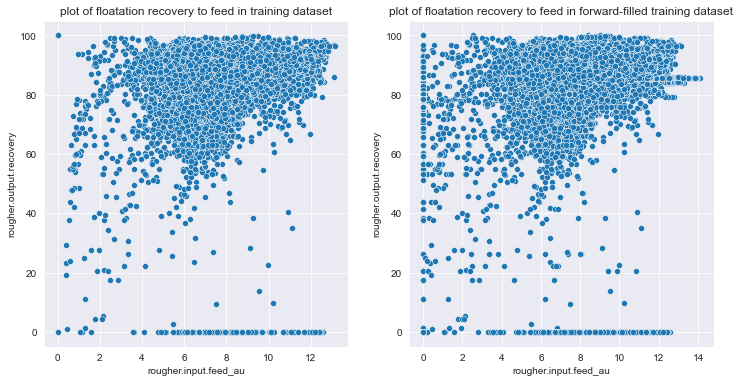

In [28]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
sns.scatterplot(x = gold_train['rougher.input.feed_au'],
               y = gold_train['rougher.output.recovery'])
plt.title('plot of floatation recovery to feed in training dataset')

plt.subplot(1,2,2)
sns.scatterplot(x = ffill_train['rougher.input.feed_au'],
               y = ffill_train['rougher.output.recovery'])
plt.title('plot of floatation recovery to feed in forward-filled training dataset')
plt.show()



Forward-filling definitely makes the correlation less clear than the original data, but it isn't as bad as with interpolation, by a small margin.

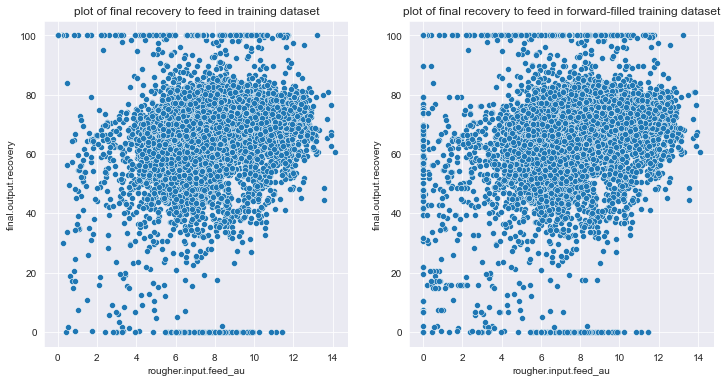

In [29]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
sns.scatterplot(x = gold_train['rougher.input.feed_au'],
               y = gold_train['final.output.recovery'])
plt.title('plot of final recovery to feed in training dataset')

plt.subplot(1,2,2)
sns.scatterplot(x = ffill_train['rougher.input.feed_au'],
               y = ffill_train['final.output.recovery'])
plt.title('plot of final recovery to feed in forward-filled training dataset')
plt.show()


Many of the values filled were outliers in the first place.

In [30]:
clean_train = gold_train[['rougher.output.recovery','rougher.output.concentrate_au',
                         'rougher.input.feed_au','rougher.output.tail_au',
                         'final.output.recovery', 'final.output.concentrate_au',
                        'final.output.tail_au']].dropna()

clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rougher.output.recovery        14149 non-null  float64
 1   rougher.output.concentrate_au  14149 non-null  float64
 2   rougher.input.feed_au          14149 non-null  float64
 3   rougher.output.tail_au         14149 non-null  float64
 4   final.output.recovery          14149 non-null  float64
 5   final.output.concentrate_au    14149 non-null  float64
 6   final.output.tail_au           14149 non-null  float64
dtypes: float64(7)
memory usage: 884.3 KB


In [31]:


rougher_recovery = clean_train['rougher.output.recovery']
rougher_pred = recovery(c_col = clean_train['rougher.output.concentrate_au'], 
                        f_col = clean_train['rougher.input.feed_au'], 
                        t_col = clean_train['rougher.output.tail_au'],
                       ind = clean_train.index)

final_recovery = clean_train['final.output.recovery']
final_pred = recovery(c_col = clean_train['final.output.concentrate_au'], 
                        f_col = clean_train['rougher.input.feed_au'], 
                        t_col = clean_train['final.output.tail_au'],
                       ind = clean_train.index)

print('when dropping nulls instead of interpolating them: \nrougher mae',
      met.mean_absolute_error(rougher_recovery, rougher_pred),
     '\nfinal stage mae',
      met.mean_absolute_error(final_recovery, final_pred))



when dropping nulls instead of interpolating them: 
rougher mae 9.317053768151204e-15 
final stage mae 8.173525622118023e-15


This is much better.

In [32]:
gold_train[non_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.output.recovery                             14287 non-null  float64
 1   rougher.output.tail_au                              14611 non-null  float64
 2   primary_cleaner.output.concentrate_ag               16778 non-null  float64
 3   rougher.output.concentrate_au                       16778 non-null  float64
 4   final.output.tail_ag                                16794 non-null  float64
 5   rougher.output.concentrate_pb                       16778 non-null  float64
 6   primary_cleaner.output.tail_sol                     16579 non-null  float64
 7   primary_cleaner.output.tail_pb                      16761 non-null  float64
 8   rougher.calculation.floatbank11_sulfate_to_au_feed  16833 non-null  float64


In [33]:
gold_train.dropna().shape, gold_train.shape

((11017, 87), (16860, 87))

Almost 35% of data was lost when dropping nulls.

In [34]:
print('Interpolated data:')
print(train[['rougher.input.feed_au','final.output.recovery', 'rougher.output.recovery'
            ]].corr()['rougher.input.feed_au'])
print('Forward-filled data:')
print(ffill_train[['rougher.input.feed_au','final.output.recovery', 'rougher.output.recovery'
                  ]].corr()['rougher.input.feed_au'])
print('Original data, with nulls dropped:')
print(gold_train[[
    'rougher.input.feed_au','final.output.recovery', 'rougher.output.recovery'
]].dropna().corr()['rougher.input.feed_au'])

Interpolated data:
rougher.input.feed_au      1.000000
final.output.recovery      0.337400
rougher.output.recovery    0.358353
Name: rougher.input.feed_au, dtype: float64
Forward-filled data:
rougher.input.feed_au      1.000000
final.output.recovery      0.140579
rougher.output.recovery    0.318726
Name: rougher.input.feed_au, dtype: float64
Original data, with nulls dropped:
rougher.input.feed_au      1.000000
final.output.recovery      0.308561
rougher.output.recovery    0.156173
Name: rougher.input.feed_au, dtype: float64


Both filling methods significantly change the connection between the gold precent in the feed and the targets. A third of the testing data will be dropped, but I think it will still improve the final model's performance.

In [35]:
temp = gold_train.dropna()
x_train = temp.drop(non_features, axis = 1).set_index('date')
y_train = temp.set_index('date')[['final.output.recovery', 'rougher.output.recovery']]

print(y_train.shape, x_train.shape)

(11017, 2) (11017, 52)


Training features and training target prepared.

In [36]:
gold_test = gold_test.set_index('date')
y_full = gold_full.set_index('date')[['final.output.recovery', 'rougher.output.recovery']]
y_test = y_full.loc[gold_test.index, :]
temp = gold_test.join(y_test) 
#joined so that null-target observations would also be dropped
print(gold_test.shape, temp.dropna().shape)
#a little over 10% is lost, 
#and i've already found that some of them were only a feed-size and a date.
#i will be using the index of the joined dataframe 
#to remove both rows with null features and rows with null targets
x_test = gold_test.loc[temp.dropna().index, :] 
y_test = y_test.loc[x_test.index, :]

(5856, 52) (5229, 54)


Testing features and testing target prepared.

### Analyzing the Data

##### How do metal concentrations change depending on stage?

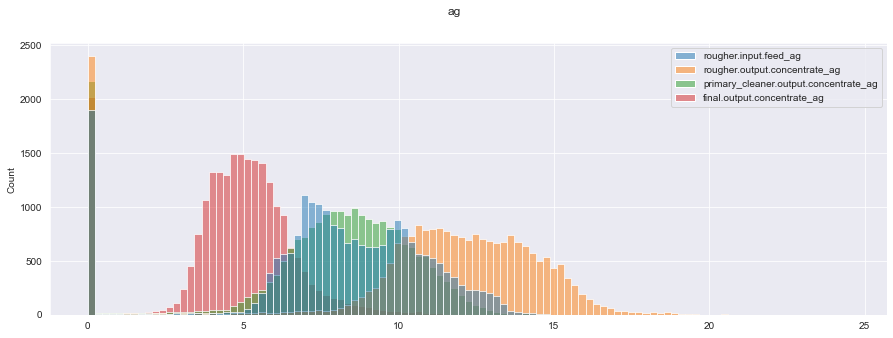

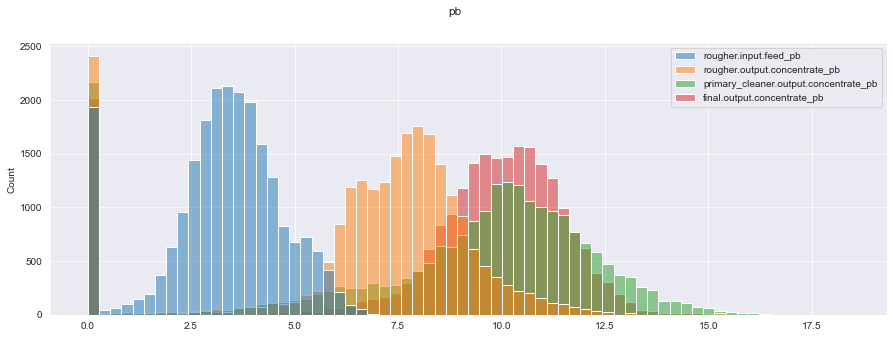

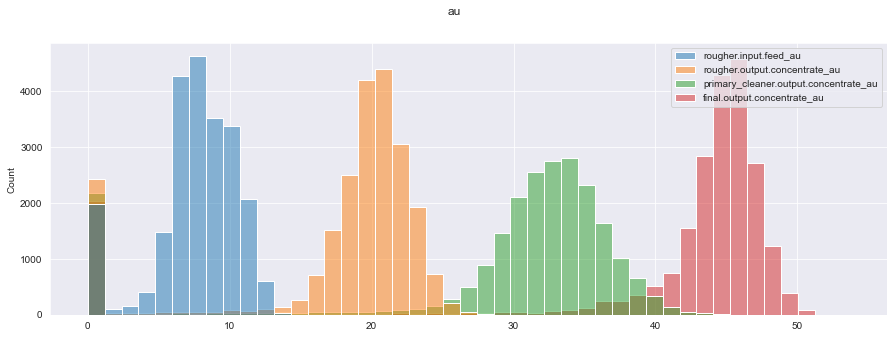

In [37]:
suffixes = ['ag', 'pb', 'au']
for metal in range(len(suffixes)): #metal ranges from 0 to 2
    fig = plt.figure(figsize = (15,5))
    fig.suptitle(suffixes[metal])
    sns.histplot(data = gold_full[['rougher.input.feed_'+suffixes[metal],
                                   "rougher.output.concentrate_"+suffixes[metal], 
                                   "primary_cleaner.output.concentrate_"+suffixes[metal], 
                                   "final.output.concentrate_"+suffixes[metal]]])

The concentrations of gold is range higher as the process proceeds, as they should.
##### Comparing training and testing datasets on feed sizes

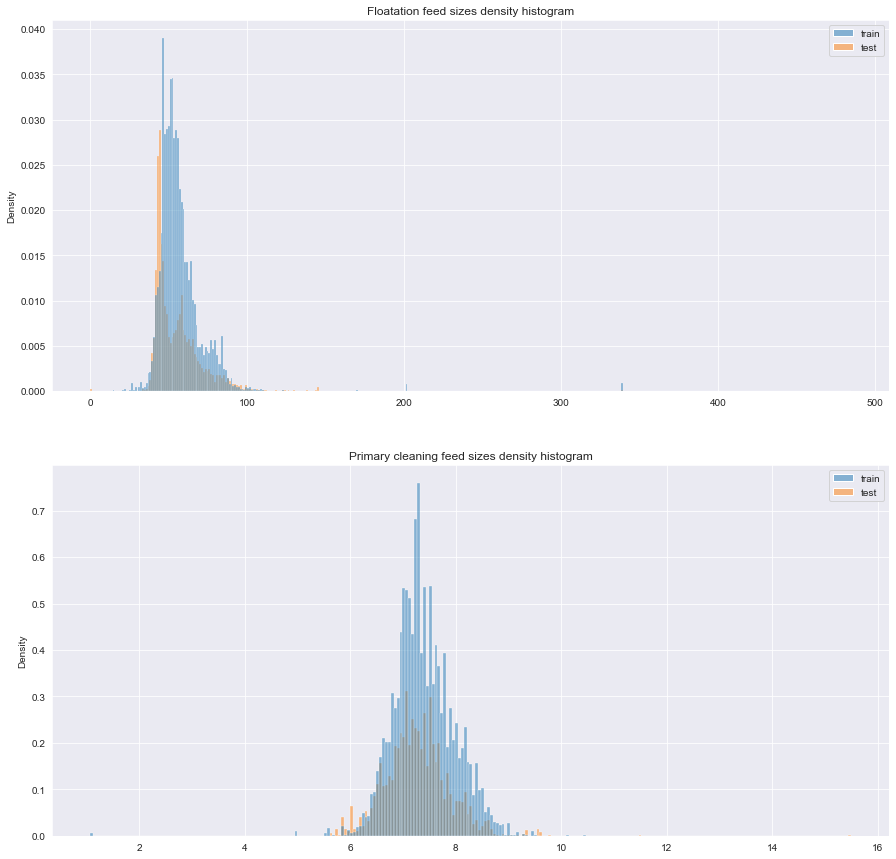

In [38]:
#rougher/primary_cleaner.input.feed_size
#comparing train to test
plt.figure(figsize = (15,15))
ax1 = plt.subplot(2,1,1)
temp = pd.concat([
    x_train['rougher.input.feed_size'].rename('train'), 
    x_test['rougher.input.feed_size'].rename('test')], axis = 1)
sns.histplot(data = temp, stat='density')
ax1.set_title("Floatation feed sizes density histogram")

ax2 = plt.subplot(2,1,2)
temp = pd.concat([
    x_train['primary_cleaner.input.feed_size'].rename('train'), 
    x_test['primary_cleaner.input.feed_size'].rename('test')], axis = 1)
sns.histplot(data = temp, stat='density')
ax2.set_title('Primary cleaning feed sizes density histogram')
plt.show()


The distribution of feed sizes for the floatation stage is significantly different in the testing data compared to the training data - the testing data has a lower peak than the training data, and the training data has a heavier low tail. I believe removeing outliers from both ends of the training data could improve predictions.

In [39]:
feed_low, feed_high = np.percentile(a = x_train['rougher.input.feed_size'], q = [2,98])
feed_low, feed_high

(39.61304388608502, 87.40829349101766)

In [40]:
feed_low, feed_high = np.percentile(a = x_train['rougher.input.feed_size'], q = [2,98])

x_train = x_train[np.logical_and(feed_high>x_train['rougher.input.feed_size'],
                                 x_train['rougher.input.feed_size']>feed_low)]

Let's see if there is an improvement.

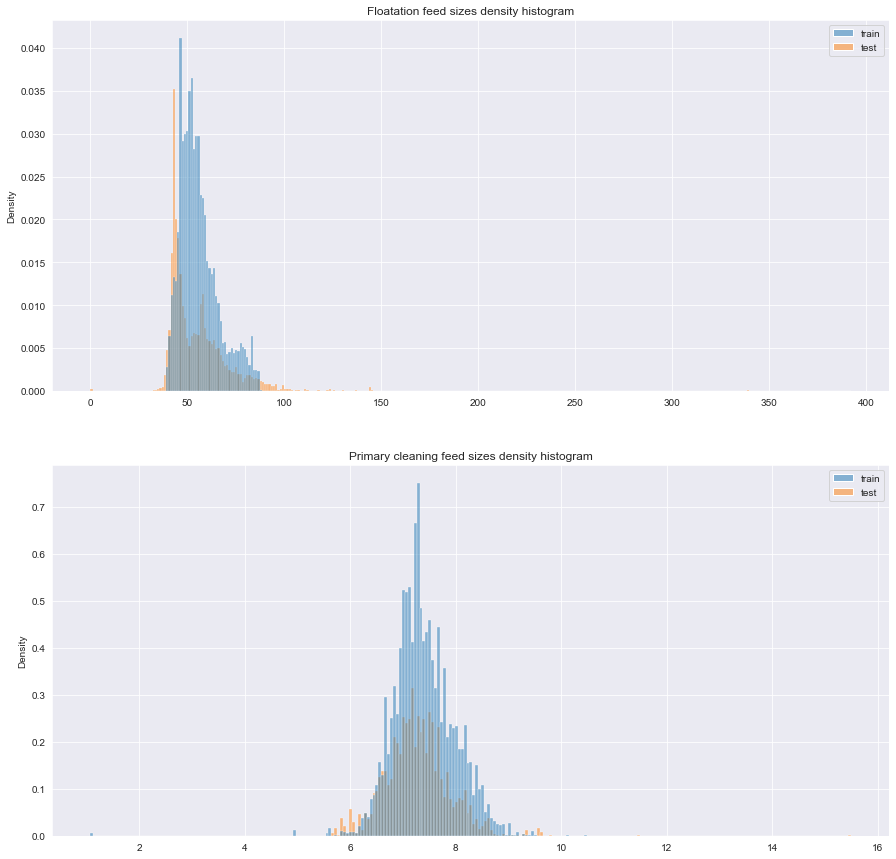

In [41]:
plt.figure(figsize = (15,15))
ax1 = plt.subplot(2,1,1)
temp = pd.concat([
    x_train['rougher.input.feed_size'].rename('train'), 
    x_test['rougher.input.feed_size'].rename('test')], axis = 1)
sns.histplot(data = temp, stat='density')
ax1.set_title("Floatation feed sizes density histogram")

ax2 = plt.subplot(2,1,2)
temp = pd.concat([
    x_train['primary_cleaner.input.feed_size'].rename('train'), 
    x_test['primary_cleaner.input.feed_size'].rename('test')], axis = 1)
sns.histplot(data = temp, stat='density')
ax2.set_title('Primary cleaning feed sizes density histogram')
plt.show()


Now the floatation feed sizes the model is trained on are in the common range - a good preparation for reality.

##### Let's look at the total concentrations at different stages

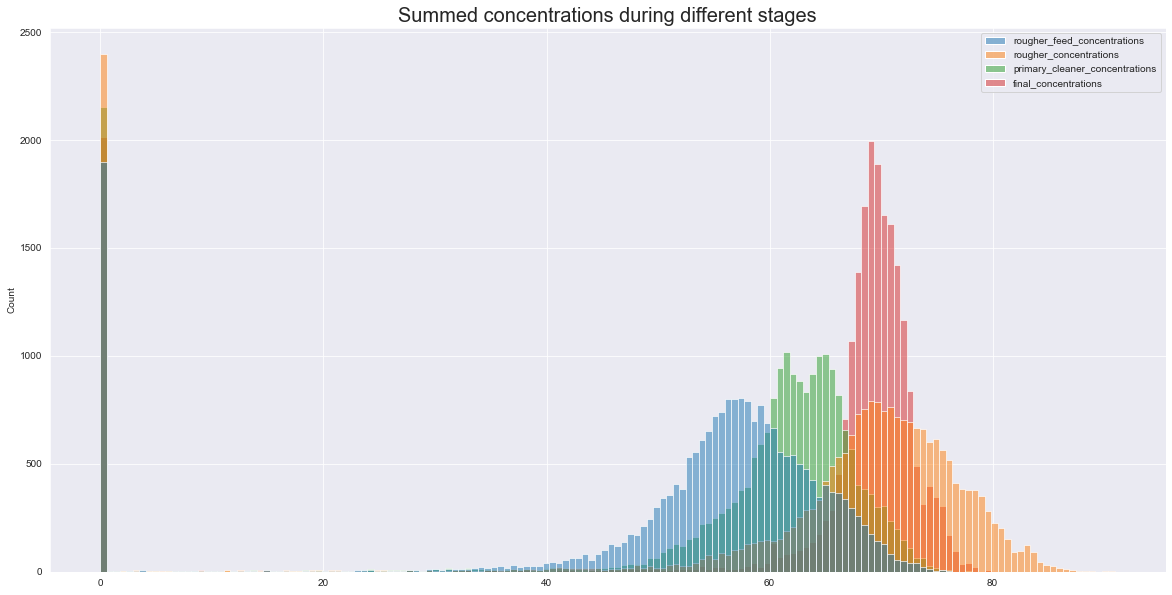

In [42]:
gold_full['rougher_feed_concentrations'] = (gold_full['rougher.input.feed_au']+
                                      gold_full['rougher.input.feed_pb']+
                                      gold_full['rougher.input.feed_ag']+
                                      gold_full['rougher.input.feed_sol'])


gold_full['rougher_concentrations'] = (gold_full['rougher.output.concentrate_au']+
                                      gold_full['rougher.output.concentrate_pb']+
                                      gold_full['rougher.output.concentrate_ag']+
                                      gold_full['rougher.output.concentrate_sol'])

gold_full['primary_cleaner_concentrations'] = (gold_full['primary_cleaner.output.concentrate_au']+
                                      gold_full['primary_cleaner.output.concentrate_pb']+
                                      gold_full['primary_cleaner.output.concentrate_ag']+
                                      gold_full['primary_cleaner.output.concentrate_sol'])

gold_full['final_concentrations'] = (gold_full['final.output.concentrate_au']+
                                      gold_full['final.output.concentrate_pb']+
                                      gold_full['final.output.concentrate_ag']+
                                      gold_full['final.output.concentrate_sol'])
plt.figure(figsize = (20,10))
sns.histplot(data = gold_full[['rougher_feed_concentrations','rougher_concentrations', 
                               'primary_cleaner_concentrations','final_concentrations']])
plt.title('Summed concentrations during different stages', fontsize = 20)

plt.show()
#over 2000 observations of processed ore containing no relevant materials
#maybe recommend a conversation with the miners

The initial feed is distributed very widely, in opposition to the final concentrations which is higly peaked around 70%.

In [43]:
#gold_full[['rougher_concentrations', 'primary_cleaner_concentrations','final_concentrations']]
print(gold_full[gold_full['rougher_feed_concentrations']==0]['rougher_feed_concentrations'].count())
print(gold_full[gold_full['rougher_concentrations']==0]['rougher_concentrations'].count())
print(gold_full[gold_full['primary_cleaner_concentrations']==0]['primary_cleaner_concentrations'].count())
print(gold_full[gold_full['final_concentrations']==0]['final_concentrations'].count())

1528
1953
1626
1613


There is a wide range of outliers on the low end of the distributions, and a peak at 0. Any row with only zeros in all concentrations are necessarily rows where we wouldn't expect any gold recovery, material can't appear out of thin air. Similarly, Rows where in some stages all concentrations are equal to 0, but in stages they are greater than zero either mean a magician caused materials to vanish or appear, or there is an error in those rows.

I will be removing rows where any stage's sum of concentrations is 0.

In [44]:
print(x_train.shape, y_train.shape)
#in the following boolean indexing, if one or more of the four statements is true,
#then the entire larger statement is true, so every index with a 0 in one of these columns is selected.
dropdate = gold_full[np.logical_or(
    np.logical_or(gold_full['rougher_feed_concentrations']==0,
                   gold_full['primary_cleaner_concentrations']==0),
    np.logical_and(gold_full['rougher_concentrations']==0,
                   gold_full['final_concentrations']==0))]['date']

#we don't want to try to remove rows that are not in the training data in the first place
traindate = x_train.index
dropdate = dropdate[dropdate.isin(traindate)]

x_train = x_train.drop(dropdate, axis = 0)
y_train = y_train.loc[x_train.index,:]
print(x_train.shape, y_train.shape)



(10575, 52) (11017, 2)
(10528, 52) (10528, 2)


Unreliable values suscessfully removed.

### Selecting a Model
##### Defining Functions
- smape
    - Accepts two one dimensional iterables of the same length, one of targets and one of predictions.
    - Calculates a symmetric absolute error for every pair of truth and prediction.
    - Returns the mean of symmetric absolute errors.
- final_smape
    - Accepts a trained estimator, a dataset of test features, and a pandas-dataframe of test targets.
    - Creates predictions for rougher recovery and final recovery and uses the smape function to calculate sMAPE for each recovery.
    - Returns the sum of 75% of the final recovery sMAPE with 25% of the rougher recovery sMAPE.

In [45]:

def smape(y_true, y_pred):
    ret = []
    for true, pred in zip(y_true, y_pred):
        temp = abs(true-pred)/(
            (abs(true)+abs(pred))/2
        )
        ret.append(temp)
    return (sum(ret)/len(ret))

def final_smape(estimator, x, y):
    y_pred = estimator.predict(x) #returns np object
    y_true_final = y['final.output.recovery']
    y_true_rougher = y['rougher.output.recovery']
    y_pred_final = y_pred[:,0]
    y_pred_rougher = y_pred[:,1]
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    return (0.25*smape_rougher)+(0.75*smape_final)


##### Cross Validation Sanity Check
Soon I will be cross-validating models, but before that I'd like to cross validate.

In [46]:
folds = sel.KFold(n_splits=5, shuffle = True, random_state = 1)

scores_dummy = []
dummy = dum.DummyRegressor(strategy = 'median') #default is always predicting mean

x_nondate = x_train
x_nondate.index = range(len(x_train)) #will not have datetime column
y_nondate = y_train
y_nondate.index = range(len(y_train)) #will not have datetime column

for train_index, valid_index in folds.split(x_nondate,y_nondate):
    x_train_train, x_valid, y_train_train, y_valid = x_nondate.loc[train_index,:], \
    x_nondate.loc[valid_index,:], y_nondate.loc[train_index,:], y_nondate.loc[valid_index,:]
    dummy.fit(x_train_train, y_train_train)
    scores_dummy.append(final_smape(dummy, x_valid, y_valid))
scores_dummy

[0.09517923153137338,
 0.09831159973175221,
 0.0961201055644407,
 0.10093309478920924,
 0.09520894761952692]

##### Cross Validation

The models evaluated are of the classes LinearRegression, SVR and Lasso.

In [47]:
folds = sel.KFold(n_splits=5, shuffle = True, random_state = 1)

scores_linear = []
scores_svr = []
scores_lasso = []

for train_index, valid_index in folds.split(x_nondate,y_nondate): #runs 5 times
    x_train_train, x_valid, y_train_train, y_valid = x_nondate.loc[train_index,:], \
    x_nondate.loc[valid_index,:], y_nondate.loc[train_index,:], y_nondate.loc[valid_index,:]
    
    linear = lin.LinearRegression()
    linear.fit(x_train_train, y_train_train)
    scores_linear.append(final_smape(linear, x_valid, y_valid))
    
    svr = svm.SVR()
    mor = mul.MultiOutputRegressor(svr)
    mor.fit(x_train_train, y_train_train)
    scores_svr.append(final_smape(mor, x_valid, y_valid))
    
    lasso = lin.Lasso(random_state = 1)
    lasso.fit(x_train_train, y_train_train)
    scores_lasso.append(final_smape(lasso, x_valid, y_valid))
print(scores_linear,'\n', scores_svr, '\n', scores_lasso)

[0.07632732720311508, 0.08046723751921259, 0.07692279192468104, 0.08041483250093243, 0.0766345631581356] 
 [0.08518686585209498, 0.08736413329680982, 0.08583114609531184, 0.0902786835733539, 0.08411632192904181] 
 [0.07875309235551808, 0.08309588522702321, 0.07961439136968025, 0.08321564106265396, 0.07814151590748573]


The sMAPEs seem low. Let's compare them.

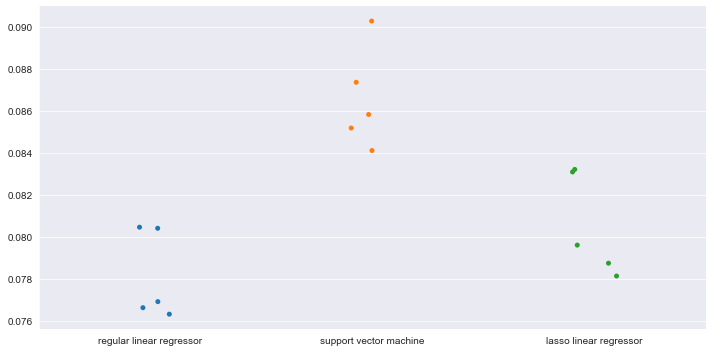

In [48]:
scores = pd.concat([pd.Series(scores_linear), 
                    pd.Series(scores_svr), pd.Series(scores_lasso)],
                  axis = 1)
scores.columns = ['regular linear regressor', 
                  'support vector machine', 'lasso linear regressor']
sns.catplot(data = scores, aspect = 2)
plt.show()
#the linear regressor did slightly better by a small margin

Impressive results for all models, with the models from the LinearRegression class having the best results by a small margin.


##### Hyperparameter Tuning

For this class they are:
- 'fit_intercept', boolean, default true. If set to false, data is expected to be centered, which this data isn't.
- 'copy_X', controls whether the data is copied, which wouldn't influence results.
- 'n_jobs', controls the processors, and so could provide speedup in processing.
- 'positive', which forces the coefficients to be positive.

The only hyperparameter that I should tune is 'positive', in my opinion.

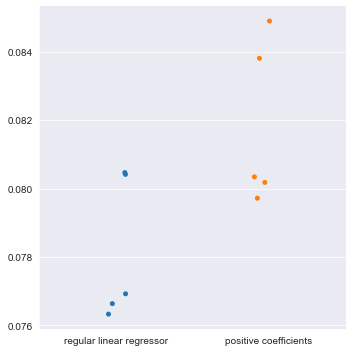

In [49]:
folds = sel.KFold(n_splits=5, shuffle = True, random_state = 1)

scores_positive = []
scores_regular = []

for train_index, valid_index in folds.split(x_nondate,y_nondate): #runs 5 times
    x_train_train, x_valid, y_train_train, y_valid = x_nondate.loc[train_index,:], \
    x_nondate.loc[valid_index,:], y_nondate.loc[train_index,:], y_nondate.loc[valid_index,:]
    
    regular = lin.LinearRegression()
    regular.fit(x_train_train, y_train_train)
    scores_regular.append(final_smape(regular, x_valid, y_valid))
    
    positive = lin.LinearRegression(positive=True)
    positive.fit(x_train_train, y_train_train)
    scores_positive.append(final_smape(positive, x_valid, y_valid))

scores = pd.concat([pd.Series(scores_regular), 
                    pd.Series(scores_positive)],
                  axis = 1)
scores.columns = ['regular linear regressor', 
                  'positive coefficients']
sns.catplot(data = scores)
plt.show()

##### Testing the Model
A model of the LinearRegression class, with default settings kept.

In [50]:
best = lin.LinearRegression()
best.fit(x_train, y_train)
print(final_smape(best, x_train, y_train))
final_smape(best, x_test, y_test)

0.07767982116424846


0.09173928718117061

The linear regressor's sMAPE when predicting for the test data is below 0.1%.

##### Sanity Check
I will use a dummy model that will predict the same value every time, in this case the median since there are plenty of outliers. I will treat the dummy's results as a baseline that my models have to surpass.

In [51]:
dummy = dum.DummyRegressor(strategy = 'median')
dummy.fit(x_train, y_train)
final_smape(dummy, x_test, y_test)

0.09170578302443222

My model does not surpass the dummy model, so I will try a different class.

##### Defining Function
lasso_tuning
- Accepts pandas dataframes of features and targets, as well as the alpha to set for the model. Alpha controls the degree to which the data is generalized (the penalty). An alpha that is too low causes overfitting, and an alpha that is too high causes underfitting. It's worth noting that Lasso with alpha=0 essentially calculates the same way a LinearRegression model does.
- It cross-validates lasso regressors with the selected alpha and the training data sent to it.
- It returns the cross validation mean.

In [63]:
def lasso_tuning(alp, x, y):
    folds = sel.KFold(n_splits=5, shuffle = True, random_state = 1)

    scores_lass = []
    lass = lin.Lasso(alpha = alp) #default is always predicting mean

    for train_index, valid_index in folds.split(x,y):
        x_train_train, x_valid, y_train_train, y_valid = x.loc[train_index,:], \
        x.loc[valid_index,:], y.loc[train_index,:], y.loc[valid_index,:]
        lass.fit(x_train_train, y_train_train)
        scores_lass.append(final_smape(lass, x_valid, y_valid))
    return sum(scores_lass)/len(scores_lass)

In [70]:
for n in range(2,25,2):
    print('With alpha',n,'lasso has an average sMAPE of',lasso_tuning(n,x_nondate,y_nondate))

With alpha 2 lasso has an average sMAPE of 0.08236611672410984
With alpha 4 lasso has an average sMAPE of 0.08293407102062177
With alpha 6 lasso has an average sMAPE of 0.08338423743918963
With alpha 8 lasso has an average sMAPE of 0.08377350459848684
With alpha 10 lasso has an average sMAPE of 0.08397071410581651
With alpha 12 lasso has an average sMAPE of 0.08415361794423884
With alpha 14 lasso has an average sMAPE of 0.08432895527721625
With alpha 16 lasso has an average sMAPE of 0.08449273484353523
With alpha 18 lasso has an average sMAPE of 0.08464341177220462
With alpha 20 lasso has an average sMAPE of 0.0848083275809785
With alpha 22 lasso has an average sMAPE of 0.0849735337320772
With alpha 24 lasso has an average sMAPE of 0.08513232862423073


In [71]:
for n in np.arange(0.1,1.1,0.1):
    print('With alpha',n,'lasso has an average sMAPE of',lasso_tuning(n,x_nondate,y_nondate))

With alpha 0.1 lasso has an average sMAPE of 0.0780401323355965
With alpha 0.2 lasso has an average sMAPE of 0.07815095149006487
With alpha 0.30000000000000004 lasso has an average sMAPE of 0.07843826091654829
With alpha 0.4 lasso has an average sMAPE of 0.07878324631218131
With alpha 0.5 lasso has an average sMAPE of 0.07903756231383696
With alpha 0.6 lasso has an average sMAPE of 0.07931924181812325
With alpha 0.7000000000000001 lasso has an average sMAPE of 0.07965432955734661
With alpha 0.8 lasso has an average sMAPE of 0.07994772467051525
With alpha 0.9 lasso has an average sMAPE of 0.08024967052504653
With alpha 1.0 lasso has an average sMAPE of 0.08056410518447224


0.1 appears to be the best.

In [72]:
best = lin.Lasso(alpha = 0.1)
best.fit(x_train, y_train)
print(final_smape(best, x_train, y_train))
final_smape(best, x_test, y_test)

0.07762692168010063


0.09057280064658012

# Conclusion
In this project I trained different machine learning models to predict gold ore recovery, both at the end of the floatation stage and at the end of the entire process.

##### Changes to the Data
- After analyzing the results of different methods of filling missing values, I dropped all rows containing any nulls.
- I also removed some outliers from the training dataset:
    - Any observation where the initial feed size was under 40.978051854101786
    - Any observation where the initial feed size was under 84.29302382834429
- I selected as target values the two columns describing recoveries.
- I selected as features only columns that were in the test dataset, since those are the values that are calculated early, and any feature calculated retroactively would give the model information that it is not supposed to have.

##### Model Selection
- Evaluation of models was done by trying to acheive a sMAPE (symmetric mean absolute error metric) that is as low as possible, adjusted so that the sMAPE of the final recovery would have more affect than the sMAPE of the floatation recovery.
- The LinearRegression models trained had the best results when cross-validated, but when trained with the full training data, it ended up overfitting.
- The Lasso models were second best during cross validation. After tuning the alpha hyperparameter of the Lasso object, it got the best results on the training dataset.
- I did a sanity check, using a DummyRegressor that always predicted the median, and it had worse results than my model.